In [1]:
import os
import numpy as np
import pandas as pd
import sklearn 

from glob import glob

# vis 
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from category_encoders import OrdinalEncoder

# modeling
import pandas as pd 
import numpy as np 

from sklearn.model_selection import KFold
from tqdm import tnrange, tqdm_notebook

import optuna
from optuna.samplers import TPESampler

import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.metrics import accuracy_score, auc, f1_score, roc_curve, classification_report

In [2]:
train_dset = pd.read_csv("..\\..\\data\\train_imputed.csv")
test_dset = pd.read_csv("..\\..\\data\\test_imputed.csv")

In [3]:
# IQR 판단 시 몇 % 삭제되는지 판단
iqr_columns = ["loan_limit", "loan_rate", "yearly_income", "desired_amount", "existing_loan_cnt", "existing_loan_amt"]

# 추가 후 unique 값 
outlier_index_ls = []
    
for idx, column in enumerate(iqr_columns) : 
    
    # 1, 3 사분위수
    q1 = train_dset[column].quantile(0.25)
    q3 = train_dset[column].quantile(0.75)
    
    iqr = q3 - q1
    iqr = iqr*1.5
    
    lowest = q1 - iqr
    highest = q3 + iqr
    
    outlier_index = train_dset[(train_dset[column] < lowest) | (train_dset[column] > highest)].index
    print(f"{column} 의 outlier 수 : {len(outlier_index)}, 전체 행 대비 {np.round(len(outlier_index) / train_dset.shape[0] * 100, 2)} %")
    
    outlier_index_ls.extend(list(outlier_index))
    
print(f"{np.round(len(np.unique(outlier_index_ls)) / train_dset.shape[0] * 100, 2)}%")

loan_limit 의 outlier 수 : 222744, 전체 행 대비 2.17 %
loan_rate 의 outlier 수 : 0, 전체 행 대비 0.0 %
yearly_income 의 outlier 수 : 713803, 전체 행 대비 6.95 %
desired_amount 의 outlier 수 : 547319, 전체 행 대비 5.33 %
existing_loan_cnt 의 outlier 수 : 716557, 전체 행 대비 6.98 %
existing_loan_amt 의 outlier 수 : 1357486, 전체 행 대비 13.23 %
25.39%


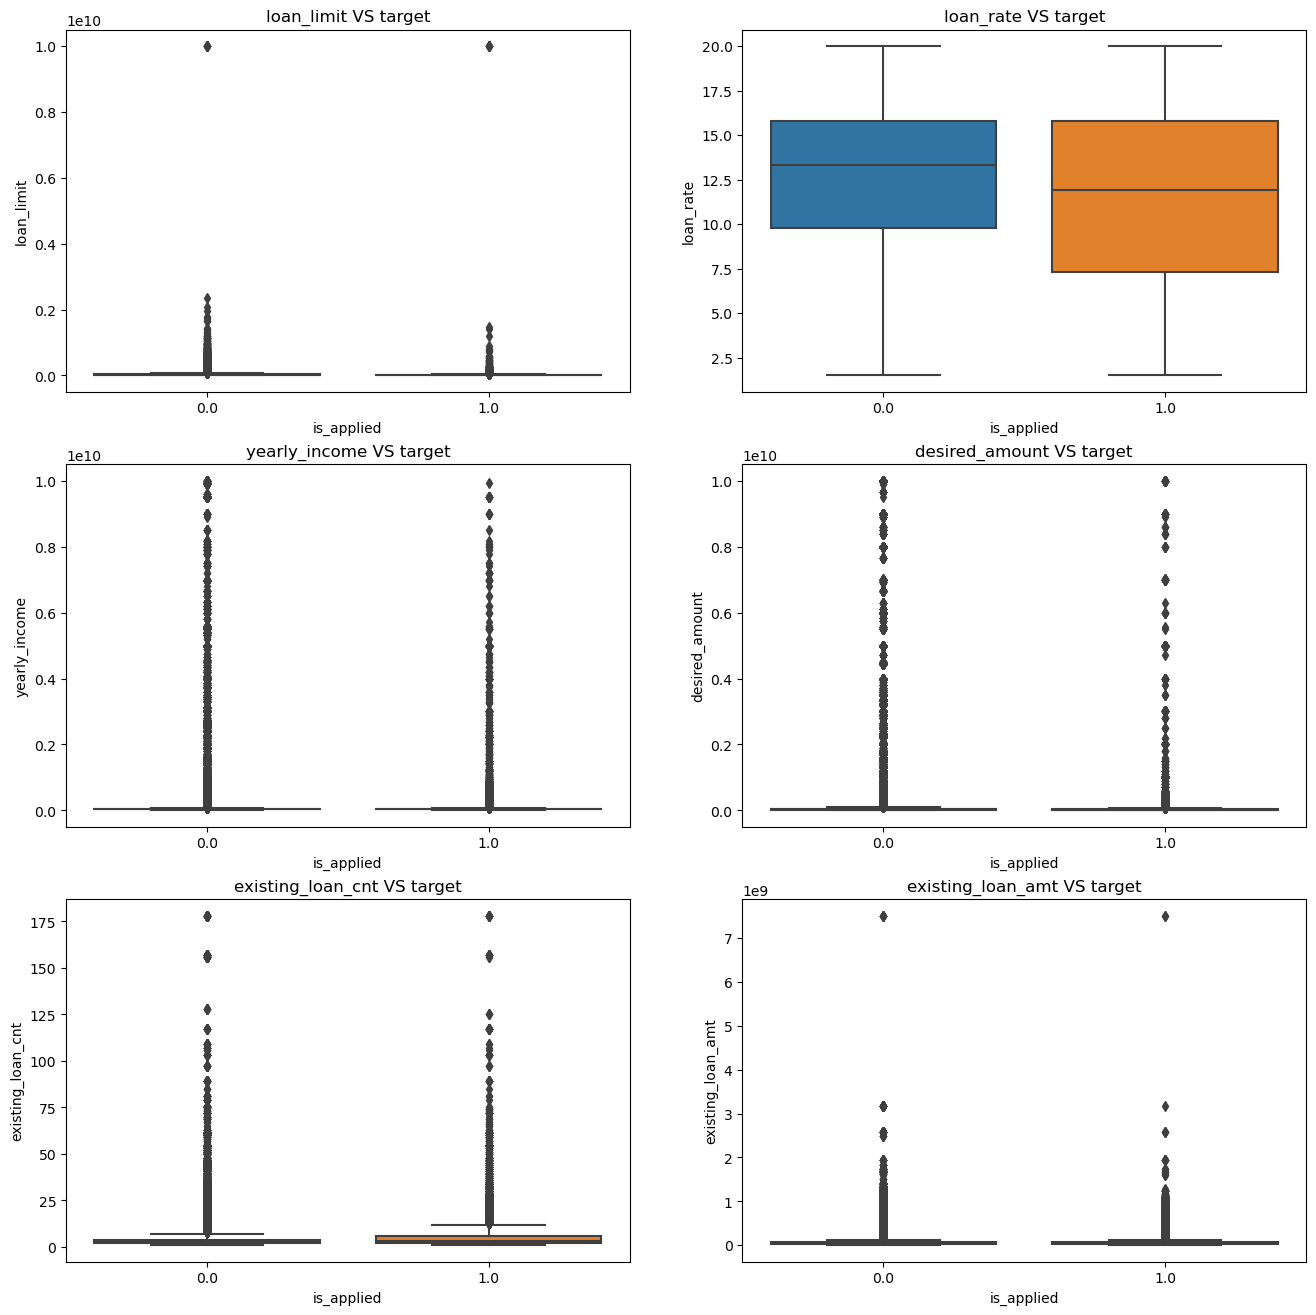

In [4]:
n_row = 3
n_col = 2

f, axes = plt.subplots(nrows = n_row, ncols = n_col, figsize = (16, 16))

for idx, col in enumerate(iqr_columns) :
    sns.boxplot(x = "is_applied", y = col, data = train_dset, ax = axes[idx//2,idx%2])
    axes[idx//2,idx%2].set_title(f"{col} VS target")

# 파생변수 추가
- credit_score => categorical variable
- bank_id 채택률을 토대로 financial_sector (금융권 추론 변수)
- product_id 채택률 => 범주형 변수 추가
- existing_loan_amt / yearly_income = 부채비율 변수 생성 : 수치가 1.5를 넘는 사람과 넘지 않는 사람 변수 생성
- desired_amount / yearly_income = 연수입 대비 원하는 금액 
- company_year * yearly_income
- loan_limit * loan_rate (원리금)
- existing_loan_amt / existing_loan_cnt (1회 대출 양 변수)
<br> 
<br> 
- 모델의 주요 변수에 따라서 새로운 파생 변수 생성 가능

In [5]:
# 1. credit_score 

def credit_kcb(x) :
    if x <=334 : return 10
    elif 335 <= x < 454 : return 9
    elif 454 <= x < 530 : return 8
    elif 530 <= x < 630 : return 7
    elif 630 <= x < 698 : return 6
    elif 698 <= x < 768 : return 5
    elif 768 <= x < 832 : return 4
    elif 832 <= x < 891 : return 3
    elif 891 <= x < 942 : return 2
    elif 942 <= x  : return 1
    
train_dset["credit_score_cat"] = train_dset["credit_score"].apply(lambda x : credit_kcb(x))
test_dset["credit_score_cat"] = test_dset["credit_score"].apply(lambda x : credit_kcb(x))

In [6]:
# 2. bank_id 활용

bank_id_ls = list(train_dset["bank_id"].unique())

cnt_low = 0
cnt = 0
cnt_10 = 0

bank_10 = []
bank_6_upper = []
bank_6_under = []

for id in bank_id_ls : 

    val_cnt = train_dset[train_dset["bank_id"] == id].is_applied.value_counts()
    total = val_cnt.sum()
    
    prob = np.round(val_cnt / total * 100, 2)
    
    if 10> prob[1] >= 6 : 
        cnt+=1
        # print(f"6% 이상 10% 미만 bank_id : {id}\n{prob}, total num : {total}")
        bank_6_upper.append(id)
        
    elif prob[1] >= 10 : 
        cnt_10+=1
        # print(f"10% 이상 bank_id : {id}\n{prob}, total num : {total}")
        bank_10.append(id)
        
    else :
        cnt_low += 1
        bank_6_under.append(id)
        
print(f"target 1 비율이 6% 이상 10% 미만 bank 수 : {cnt}")
print(f"target 1 비율이 10% 이상 넘는 bank 수 : {cnt_10}")
print(f"target 1 비율이 6% 미만 bank 수 : {cnt_low}")

# category [0, 1, 2]
def bank_id_category(x) :
    if x in bank_10 : 
        return 2
    elif x in bank_6_under :
        return 0 
    elif x in bank_6_upper : 
        return 1
    
train_dset["bank_id_cat"] = train_dset["bank_id"].apply(lambda x : bank_id_category(x))
test_dset["bank_id_cat"] = test_dset["bank_id"].apply(lambda x : bank_id_category(x))

target 1 비율이 6% 이상 10% 미만 bank 수 : 15
target 1 비율이 10% 이상 넘는 bank 수 : 9
target 1 비율이 6% 미만 bank 수 : 38


In [7]:
# 3. product_id 채택률 고려 변수

product_id_ls = list(train_dset["product_id"].unique())

cnt_low = 0
cnt = 0
cnt_10 = 0

product_10 = []
product_6_upper = []
product_6_under = []

for id in product_id_ls : 

    val_cnt = train_dset[train_dset["product_id"] == id].is_applied.value_counts()
    total = val_cnt.sum()
    
    prob = np.round(val_cnt / total * 100, 2)
    if len(prob) >= 2 :
        if 10> prob[1] >= 6 : 
            cnt+=1
            # print(f"6% 이상 10% 미만 bank_id : {id}\n{prob}, total num : {total}")
            product_6_upper.append(id)

        elif prob[1] >= 10 : 
            cnt_10+=1
            # print(f"10% 이상 bank_id : {id}\n{prob}, total num : {total}")
            product_10.append(id)

        else :
            cnt_low += 1
            product_6_under.append(id)
            
    elif len(prob) <= 1 :
            cnt_low += 1
            product_6_under.append(id)

        
print(f"target 1 비율이 6% 이상 10% 미만 product 수 : {cnt}")
print(f"target 1 비율이 10% 이상 넘는 product 수 : {cnt_10}")
print(f"target 1 비율이 6% 미만 product 수 : {cnt_low}")

# category [0, 1, 2]
def product_id_category(x) :
    if x in product_10 : 
        return 2
    elif x in product_6_under :
        return 0 
    elif x in product_6_upper : 
        return 1
    
train_dset["product_id_cat"] = train_dset["product_id"].apply(lambda x : product_id_category(x))
test_dset["product_id_cat"] = test_dset["product_id"].apply(lambda x : product_id_category(x))


target 1 비율이 6% 이상 10% 미만 product 수 : 32
target 1 비율이 10% 이상 넘는 product 수 : 28
target 1 비율이 6% 미만 product 수 : 108


In [8]:
# existing_loan_amt / existing_loan_cnt = 1회 대출 양

train_dset["loan_amt_per_once"] = train_dset["existing_loan_amt"] / train_dset["existing_loan_cnt"]
test_dset["loan_amt_per_once"] = test_dset["existing_loan_amt"] / test_dset["existing_loan_cnt"]

In [9]:
# existing_loan_amt / yearly_income = 부채비율 변수 생성 : 수치가 1.5를 넘는 사람과 넘지 않는 사람 변수 생성

train_dset["debt_ratio"] = train_dset["existing_loan_amt"] / (train_dset["yearly_income"] + 1)
test_dset["debt_ratio"] = test_dset["existing_loan_amt"] / (test_dset["yearly_income"] + 1)

train_dset["over_debt"] = train_dset["debt_ratio"].apply(lambda x : 1 if x > 1.5 else 0)
test_dset["over_debt"] = test_dset["debt_ratio"].apply(lambda x : 1 if x > 1.5 else 0)

In [10]:
# desired_amount / yearly_income = 연수입당 원하는 금액 

train_dset["da_per_income"] = train_dset["desired_amount"] / (train_dset["yearly_income"] + 1)
test_dset["da_per_income"] = test_dset["desired_amount"] / (test_dset["yearly_income"] + 1)

In [11]:
# loan_limit * loan_rate (원리금) principal and interest

train_dset["pai"] = train_dset["loan_limit"] * train_dset["loan_rate"]
test_dset["pai"] = test_dset["loan_limit"] * test_dset["loan_rate"]

In [12]:
# company_year * yearly_income = 총 수입 

train_dset["total_income"] = train_dset["company_year"] * train_dset["yearly_income"]
test_dset["total_income"] = test_dset["company_year"] * test_dset["yearly_income"]

In [13]:
# train_more_dv 파생변수 추가 데이터
train_dset.to_csv("..\\..\\data\\train_more_dv.csv", index = False)
test_dset.to_csv("..\\..\\data\\test_more_dv.csv", index = False)